In [250]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm, tqdm_notebook
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

utils

In [43]:
from skimage.measure import label, regionprops
from skimage.morphology import label

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def mask_overlay(image, mask):
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.75, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

Augmentation

In [88]:
df = pd.read_csv("train_ship_segmentations.csv", header=0)

In [89]:
df_ship = df[pd.notnull(df['EncodedPixels'])]

In [90]:
df_ship_unique = df_ship.drop_duplicates("ImageId")

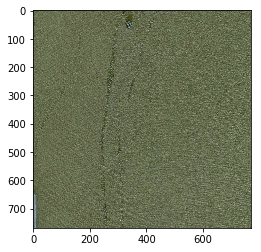

In [87]:
img = cv2.imread('all/train/0002756f7.jpg')
plt.imshow(img)
rle_0 = df.query('ImageId=="0528f0737.jpg"')['EncodedPixels'].tolist()
mask = masks_as_image(rle_0)

#### Split train / test with augmentation

In [44]:
df = pd.read_csv("train_ship_segmentations.csv", header=0)
df_unique = df.drop_duplicates("ImageId")

In [45]:
train, test = train_test_split(shuffle(df_unique), test_size=0.2)


  1%|          | 494/83255 [00:20<58:18, 23.65it/s] 

In [6]:
train["ImageId"].to_csv("augmentation/train1.csv", header=False)
test["ImageId"].to_csv("augmentation/test1.csv", header=False)

In [57]:
imgs = []
label = []
i = 1
f = 0
mean = []
for x in tqdm(train["ImageId"].tolist()):
    img = cv2.imread('all/train/'+x)
    
    #rle_0 = df.query('ImageId=="'+x+'"')['EncodedPixels'].tolist()
    #mask = masks_as_image(rle_0)
    
    
#     if str(rle_0[0]) == 'nan':
#         label.append(0)
#     else:
#         label.append(1)
    
    imgs.append(img)
    
    
    if i % 4000 == 0 :
        imgs = np.array(imgs)
        np.save("all/numpy/test-"+str(f), imgs)
        mean.append( np.mean(imgs, axis=0) )
        imgs = []
        f += 1
#         with open("test.txt", "a") as myfile:
#             myfile.write("\n".join(imgs))
#         imgs = []
#         break
    
    i += 1

100%|██████████| 83255/83255 [18:28<00:00, 75.11it/s]


In [60]:
np.save("all/numpy/test-"+str(f), imgs)

In [61]:
mean.append( np.mean(imgs, axis=0) )

In [79]:
all_mean = np.mean(mean, axis=0)
all_mean
np.save("mean", all_mean)

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
pp_mean = np.mean(np.concatenate((x_train, x_test), axis=0), axis=0)

### Data augmentation

In [251]:
from joblib import Parallel, delayed
import imgaug as ia
from imgaug import augmenters as iaa
import multiprocessing
import os
import Augmentor
size = 350
if not os.path.exists("all/resize/"+str(size)):
    os.makedirs("all/resize/"+str(size))
    os.makedirs("all/resize/"+str(size)+"/ship")
    os.makedirs("all/resize/"+str(size)+"/noship")

In [252]:
df = pd.read_csv("train_ship_segmentations.csv", header=0)
df_unique = df.drop_duplicates("ImageId")

In [ ]:
# Resize
sometimes1 = lambda aug: iaa.Sometimes(0.10, aug)
sometimes3 = lambda aug: iaa.Sometimes(0.30, aug)

def processInput(i):
    
    img = cv2.imread("all/train/"+i)
    img_resized = cv2.resize(img, (size,size))
    
    encoded = df.query('ImageId=="'+i+'"')['EncodedPixels'].tolist()
    if str(encoded[0]) == 'nan':
        name = "noship"
        seq = iaa.Sequential([
            sometimes1(iaa.CoarseSalt(p=0.07, size_percent=0.02)),
            sometimes1(iaa.GaussianBlur((0, 2.0)))
        ])
        images_aug = seq.augment_images([img_resized])
        img_resized = images_aug[0]
        cv2.imwrite("all/resize/"+str(size)+"/"+str(name)+"/"+i,img_resized)
        
    else:
        name = "ship"
        cv2.imwrite("all/resize/"+str(size)+"/"+str(name)+"/"+i,img_resized)
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            sometimes3(iaa.CoarseSalt(p=0.07, size_percent=0.02)),
            sometimes3(iaa.Affine(rotate=(-45, 45))),
            sometimes3(iaa.GaussianBlur((0, 2.0)))
        ])
        images_aug = seq.augment_images([img_resized])
        cv2.imwrite("all/resize/"+str(size)+"/"+str(name)+"/2-"+i,images_aug[0])
    
    
    
    

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in df_unique["ImageId"].tolist())

/home/ubuntu/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:686: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print("FINIIIIIIIIIIIIIII")
print("FINIIIIIIIIIIIIIII")
print("FINIIIIIIIIIIIIIII")

In [44]:
# Data augmentation

In [206]:
p = Augmentor.Pipeline("all/resize/350/ships")
p.rotate90(probability=0.3)
p.rotate270(probability=0.3)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)
p.flip_random(probability=0.1)
p.random_erasing(probability=0.3, rectangle_area=0.2)
# p.resize(probability=1.0, width=120, height=120)
#p.sample(10000)

Initialised with 0 image(s) found.
Output directory set to all/resize/350/ships/output.

With augmin

<function <lambda> at 0x1c26e9e378>


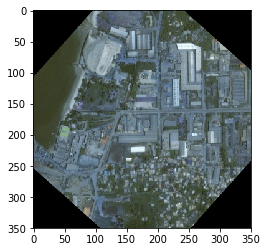

In [404]:

img = cv2.imread("all/resize/350/ships/00021ddc3.jpg")
seq = iaa.Sequential([
    iaa.Sometimes(0.50, iaa.Fliplr(0.5)),
    iaa.Sometimes(0.50, iaa.Flipud(0.5)),
    sometimes(iaa.CoarseSalt(p=0.10, size_percent=0.02)),
    sometimes(iaa.Affine(rotate=(-45, 45))),
    sometimes(iaa.GaussianBlur((0, 3.0)))
])

images_aug = seq.augment_images([img])
plt.imshow(images_aug[0])

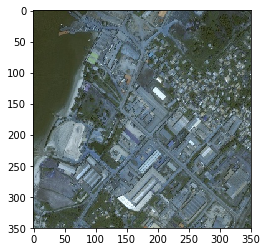

In [409]:
img = cv2.imread("all/resize/350/ships/00021ddc3.jpg")
seq = iaa.Sequential([
    iaa.Sometimes(0.50, iaa.Fliplr(0.5)),
    iaa.Sometimes(0.50, iaa.Flipud(0.5)),
    sometimes(iaa.CoarseSalt(p=0.10, size_percent=0.02)),
    sometimes(iaa.Affine(rotate=(-25, 25))),
    sometimes(iaa.GaussianBlur((0, 3.0)))
])

images_aug = seq.augment_images([img])
plt.imshow(images_aug[0])

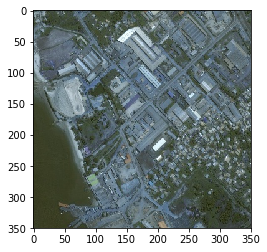

In [386]:
plt.imshow(cv2.imread("all/resize/350/ships/00021ddc3.jpg"))

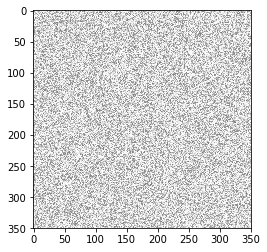

In [148]:
#plt.imshow(img)